<a href="https://colab.research.google.com/github/A01745336/Modulo2/blob/main/Momento_de_Retroalimentaci%C3%B3n_M%C3%B3dulo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Selección de problema**

El problema que se buscará resolver en este notebook, que corresponde con el entregable del modulo 2 (Deep Learning), consiste en hacer un modelo que sea capaz de identificar la especie de un ave con base en solo fotos de la misma. Para ello se hará uso de un dataset de kaggle llamado "BIRDS 525 SPECIES - IMAGE CLASSIFICATION" y se ubica en: https://www.kaggle.com/code/pedrolucasbritodes/bird-image-classification-cnn-89-accuracy


# **Selección del Dataset**

Como se dijo anteriormente, se usará un dataset de imagenes ubicado en Kaggle.  Para hacer uso de este, se hará uso del API de Kaggle, para ello se necesitará el archivo .json que se puede descargar de Kaggle para hacer uso de su API.  Posteriormente se descargará el dataset y se descomprimerá en el entorno de Google Colab.

In [2]:
from google.colab import files

# Selecciona el archivo kaggle.json que descargaste
uploaded = files.upload()


Saving kaggle (1).json to kaggle (1).json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle datasets download -d gpiosenka/100-bird-species


100% 1.95G/1.96G [00:54<00:00, 43.1MB/s]
100% 1.96G/1.96G [00:54<00:00, 38.4MB/s]


In [8]:
import zipfile
import os

# Nombre del archivo ZIP que descargaste
zip_filename = "100-bird-species.zip"

# Directorio de destino para extraer los archivos
extract_path = "/content/dataset"

# Crear el directorio si no existe
os.makedirs(extract_path, exist_ok=True)

# Extraer el contenido del archivo ZIP
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Directorios de entrenamiento, prueba y validación
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'
val_dir = '/content/dataset/valid'

# **Prepocesamiento de los datos**

El dataset cuenta con 525 especies de aves, 84635 imagenes para el entrenamiento, 2625 para test y 2625 de validación.  Acontinuación se mostrarán ejemplos de las imagenes

Total Classes:  525


array([[[183, 170, 154],
        [182, 169, 153],
        [177, 164, 148],
        ...,
        [177, 165, 143],
        [177, 165, 143],
        [177, 165, 143]],

       [[183, 170, 154],
        [183, 170, 154],
        [181, 168, 152],
        ...,
        [177, 165, 143],
        [177, 165, 143],
        [177, 165, 143]],

       [[180, 167, 151],
        [180, 167, 151],
        [181, 168, 152],
        ...,
        [177, 165, 143],
        [177, 165, 143],
        [177, 165, 143]],

       ...,

       [[124, 101,  60],
        [139, 117,  76],
        [129, 106,  65],
        ...,
        [199, 176, 124],
        [196, 173, 123],
        [196, 173, 123]],

       [[128, 103,  62],
        [143, 120,  78],
        [139, 114,  73],
        ...,
        [198, 175, 123],
        [196, 173, 123],
        [197, 174, 124]],

       [[147, 123,  79],
        [176, 152, 108],
        [171, 146, 105],
        ...,
        [199, 176, 124],
        [205, 182, 132],
        [202, 179, 129]]

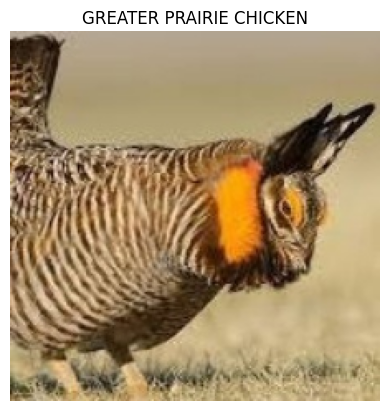

In [10]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def image_example(dir, classes):
  path = dir + "/" + classes
  random_image = random.sample(os.listdir(path), 1)

  img = mpimg.imread(path + "/" + random_image[0])

  plt.imshow(img)
  plt.title(classes)
  plt.axis("off")

  return img

classes = os.listdir(train_dir)
n_classes = len(classes)
print ("Total Classes: ", n_classes)

image_example(train_dir, classes[random.randint(0, n_classes)])

array([[[108, 139, 167],
        [108, 139, 167],
        [108, 139, 168],
        ...,
        [201, 204, 211],
        [196, 199, 208],
        [190, 193, 202]],

       [[108, 139, 167],
        [108, 139, 167],
        [108, 139, 168],
        ...,
        [198, 201, 208],
        [193, 196, 205],
        [188, 191, 200]],

       [[108, 139, 168],
        [108, 139, 168],
        [108, 139, 168],
        ...,
        [196, 200, 209],
        [191, 195, 204],
        [186, 190, 199]],

       ...,

       [[ 43,  43,  41],
        [ 42,  43,  38],
        [ 42,  43,  38],
        ...,
        [ 74,  72,  75],
        [ 73,  71,  72],
        [ 44,  42,  43]],

       [[ 53,  52,  48],
        [ 53,  52,  47],
        [ 52,  51,  46],
        ...,
        [ 80,  78,  81],
        [ 73,  71,  72],
        [ 38,  37,  35]],

       [[ 61,  60,  55],
        [ 61,  60,  55],
        [ 60,  60,  52],
        ...,
        [ 84,  82,  83],
        [ 74,  72,  73],
        [ 37,  36,  34]]

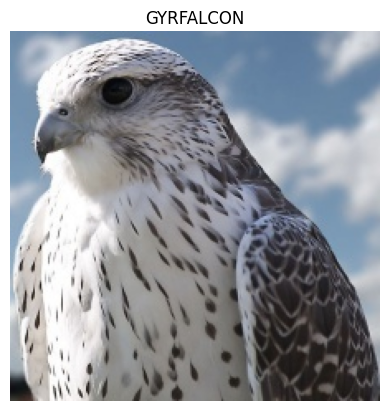

In [11]:
image_example(test_dir, classes[random.randint(0,n_classes)])

Al tener muchas clases en los conjuntos de entranmiento, test y validación, corremos el riesgo que las clases no esten bien definadas para ello realizaremos una verificación en los conjuntos para ver si hay alguna clases que falte o si estan todas las que deberían estar

In [13]:
train_directory = train_dir
test_directory = val_dir

train_files = set(os.listdir(train_directory))
test_files = set(os.listdir(test_directory))

mismatched_files = [test_file for test_file in test_files if test_file not in train_files]
num_mismatches = len(mismatched_files)

if num_mismatches == 0:
    print("Todas las clases de test estan en el entranmiento")
else:
    print(f"{num_mismatches} archivo(s) que esta en el conjunto de test no esta en el de entramiento")
    print("Archivo(s) faltante(s)")
    for mismatched_file in mismatched_files:
        print(f"- {mismatched_file}")

1 archivo(s) que esta en el conjunto de test no esta en el de entramiento
Archivo(s) faltante(s)
- PARAKETT AUKLET


In [15]:
# Instala TensorFlow y otras bibliotecas necesarias
!pip install tensorflow


In [16]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout,GlobalMaxPooling2D,Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Set the Data Generators to preprocess the data

tr_datagen = ImageDataGenerator(rescale = 1/225)
val_datagen = ImageDataGenerator(rescale = 1/225)
te_datagen = ImageDataGenerator(rescale = 1/225)

# Loading the data from the directories
train_data = tr_datagen.flow_from_directory(train_dir,batch_size=32, target_size = (224,224), class_mode = "categorical")

val_data = val_datagen.flow_from_directory(val_dir,batch_size=32, target_size = (224,224), class_mode = "categorical")

test_data = te_datagen.flow_from_directory(test_dir,batch_size=32, target_size = (224,224), class_mode = "categorical")

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


# **Implementación arquitectura**

Para el primer intento, que busca resolver el problema planteado, se utilizo un modelo preentrenado, el cual es InceptionV3, este modelo ha sido entranando en un gran conjunto de datos de imágenes y cuenta con capas covolucionales profundas que logran una gran eficiencia para extraer características complejas de las imágenes.  Posteriormente "congelamos" los pesos del modelo preentranado para evitar la actualización durante el entramiento de la red personalizada.  Además de hacer uso del modelo IncepcitionV3 al modelo actual se le agrega una capa de Global Average Pooling con la finalidad de reducir la dimensionalidad de las características extraídas y asi tener una versión más compacta de la información relevante de la imagen.  También se hace uso de capas densas, con activación ReLU, Batch Normalization y Dropout para prevenir el sobreajuste y normalizar las activaciones.  Por último tenemos una capa de salida con activación softmax para realizar la clasificación de las clases.

In [17]:
# Load the InceptionV3 model with pre-trained weights
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model.trainable = False

model = tf.keras.Sequential()

# Add the base model (InceptionV3) to the Sequential model
model.add(base_model)

model.add(tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer"))

model.add(tf.keras.layers.Dense(512, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(len(classes), activation="softmax", name="output-layer"))

base_learning_rate = 0.01

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=adam_optimizer,
    metrics=["accuracy"]
)

model.summary()

87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling_lay  (None, 2048)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_94 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 512)               0 

# **Entrenamiento del modelo**

Este modelo se entreno con 18 epocas

In [18]:
#Setting the early_stop to avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=3,
    min_delta=0.001,
    restore_best_weights=True,)


history = model.fit(
    train_data,
    epochs=18,
    steps_per_epoch=len(train_data),
    validation_data=val_data,
    validation_steps=int(0.25 * len(val_data)),
    callbacks=[early_stop],
)

Epoch 1/18
2645/2645 [==============================] - 239s 85ms/step - loss: 2.4941 - accuracy: 0.4070 - val_loss: 1.1961 - val_accuracy: 0.6453
Epoch 2/18
2645/2645 [==============================] - 240s 91ms/step - loss: 1.6454 - accuracy: 0.5735 - val_loss: 1.0455 - val_accuracy: 0.7000
Epoch 3/18
2645/2645 [==============================] - 221s 84ms/step - loss: 1.4634 - accuracy: 0.6156 - val_loss: 0.8484 - val_accuracy: 0.7688
Epoch 4/18
2645/2645 [==============================] - 214s 81ms/step - loss: 1.3577 - accuracy: 0.6421 - val_loss: 0.8497 - val_accuracy: 0.7531
Epoch 5/18
2645/2645 [==============================] - 213s 81ms/step - loss: 1.2831 - accuracy: 0.6606 - val_loss: 0.7029 - val_accuracy: 0.7859
Epoch 6/18
2645/2645 [==============================] - 214s 81ms/step - loss: 1.2203 - accuracy: 0.6764 - val_loss: 0.6859 - val_accuracy: 0.7797
Epoch 7/18
2645/2645 [==============================] - 214s 81ms/step - loss: 1.1811 - accuracy: 0.6870 - val_loss: 0

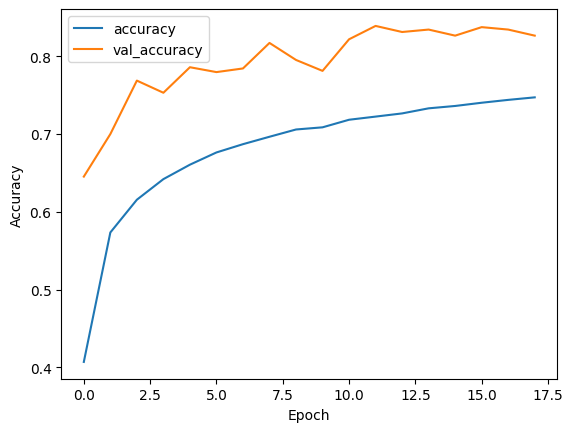

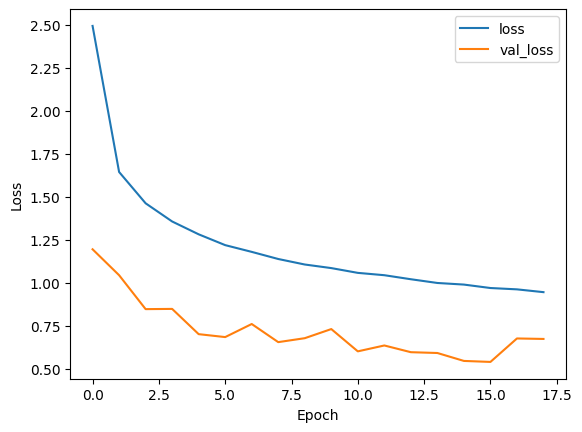

83/83 [==============================] - 11s 132ms/step - loss: 0.4859 - accuracy: 0.8579
Test Accuracy: 85.79%
Test Loss: 0.4859144389629364


In [20]:
import matplotlib.pyplot as plt

# Visualizar la precisión del entrenamiento y la validación
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualizar la pérdida del entrenamiento y la validación
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluación en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss}')


# **Resultados Primer modelo**

Como se puede ver en las gráficas anteriores, el modelo no presenta Sobreajuste(Overfitting).  Tiene una precisión de 85.79% para predecir las clases de imagenes que nunca había visto.  Sin embargo, en la teoría aun se podría mejorar este modelo si se logra "descongelar" los valores del modelo base que previamente "congelamos" para evitar la actualización de este mismo.

# **Implementación Nueva Arquitectura**

Para esta nueva implementación en busqueda de mejorar el modelo, lo primero que se hará, es ver el numero de capas que tiene el modelo base y con base en ello se decidirá cuantas capas siguen "congeladas" y en cuantas permitiremos la actualización de los pesos

In [22]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


Se pobrará desconquelar al rededor del 20% de las capas del modelo con la finalidad de actualizar los valores de los pesos del modelo preentrenado y asi mejorar la precisión de nuestro modelo

In [23]:
fine_tune_at = 250

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [24]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/100)

model.compile(
    loss="categorical_crossentropy",
    optimizer=adam_optimizer,
    metrics=["accuracy"]
)

Y debido al tiempo de entramiento, se usará los valores de los pesos de la mejor epoca de entrenamiento pasada

In [25]:
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=4,
    min_delta=0.001,
    restore_best_weights=True,)


fine_tune_epochs = 12
total_epochs =  18 + fine_tune_epochs

history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         steps_per_epoch=len(train_data),
                         validation_data=val_data,
                         validation_steps=int(0.25 * len(val_data)),
                         callbacks=[early_stop])

Epoch 18/30
2645/2645 [==============================] - 235s 87ms/step - loss: 0.7374 - accuracy: 0.7929 - val_loss: 0.4692 - val_accuracy: 0.8578
Epoch 19/30
2645/2645 [==============================] - 217s 82ms/step - loss: 0.6596 - accuracy: 0.8114 - val_loss: 0.5112 - val_accuracy: 0.8516
Epoch 20/30
2645/2645 [==============================] - 220s 83ms/step - loss: 0.6326 - accuracy: 0.8196 - val_loss: 0.4509 - val_accuracy: 0.8703
Epoch 21/30
2645/2645 [==============================] - 218s 82ms/step - loss: 0.6206 - accuracy: 0.8227 - val_loss: 0.3754 - val_accuracy: 0.8875
Epoch 22/30
2645/2645 [==============================] - 217s 82ms/step - loss: 0.6073 - accuracy: 0.8249 - val_loss: 0.4298 - val_accuracy: 0.9031
Epoch 23/30
2645/2645 [==============================] - 215s 81ms/step - loss: 0.5982 - accuracy: 0.8272 - val_loss: 0.4539 - val_accuracy: 0.8797
Epoch 24/30
2645/2645 [==============================] - 216s 81ms/step - loss: 0.5966 - accuracy: 0.8291 - val_

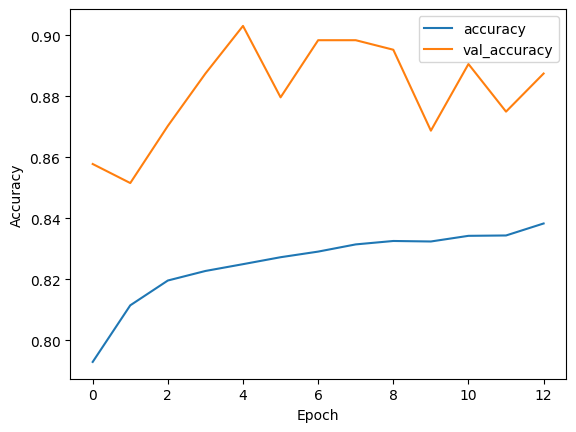

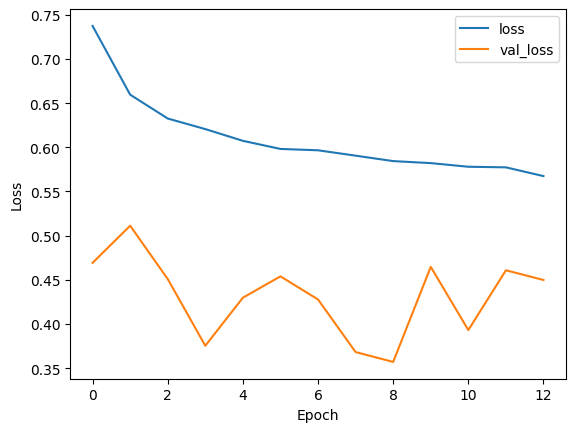

83/83 [==============================] - 7s 81ms/step - loss: 0.3304 - accuracy: 0.9017
Test Accuracy: 90.17%
Test Loss: 0.33044591546058655


In [26]:
import matplotlib.pyplot as plt

# Visualizar la precisión del entrenamiento y la validación
plt.plot(history_fine.history['accuracy'], label='accuracy')
plt.plot(history_fine.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualizar la pérdida del entrenamiento y la validación
plt.plot(history_fine.history['loss'], label='loss')
plt.plot(history_fine.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluación en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss}')

# **Resultados Segundo Intento**

Con los cambios realizados podemos ver que tanto la perdida como el acurrency del conjunto de validación tienen picos y valles más notorios que el modelo pasado.  Esto puede que se deba a que una mayor cantidad de pesos se estan actualizando cada epoca y si bien solo hubo una mejoría de 5% respecto al modelo pasado se puede llegar a decir que los cambios que se realizaron fueron buenos para mejorar el modelo a pesar de utilizar los valores ya existentes en vez de entrenar desde 0.  Ya que viendo el comportamiento en el primer modelo puede que el modelo no pudiera mejorar tanto como si lo hizo con los cambios realizados para el segundo modelo

# **Predicciones**

Esta sección del notebook se usará para mostrar las predicciones que el modelo realizó.  Además se le presentará al usuario como hacer predicciones con valores completamente nuevos y ajenos a las imagenes que vienen en el proyecto.

In [31]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.image as mpimg



def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size);
    img_array = image.img_to_array(img);
    img_array = np.expand_dims(img_array, axis=0);
    img_array /= 255.0  # Normalize the image
    return img_array

def display_image_and_prediction(model, generator, class_name):
    folder_path = os.path.join(generator.directory, class_name);

    random_image = random.choice(os.listdir(folder_path));
    img_path = os.path.join(folder_path, random_image);

    # Load and preprocess the image
    img_array = load_and_preprocess_image(img_path);

    # Display the image
    img = mpimg.imread(img_path);

    # Make a prediction
    prediction = model.predict(img_array);
    predicted_class = np.argmax(prediction);
    predicted_class_name = list(generator.class_indices.keys())[predicted_class];

    if class_name==predicted_class_name: #Paint the title of green if pred is correct and red if it is not
        color='green'
    else:
        color='red'

    plt.imshow(img)
    plt.title(f"Real: {class_name} ||| Pred: {predicted_class_name}", color=color)
    plt.axis("off")
    plt.show()

1/1 [==============================] - 0s 44ms/step


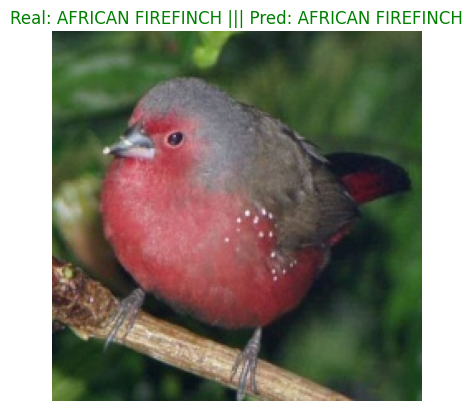

In [44]:
display_image_and_prediction(model, test_data, classes[random.randint(0,n_classes)])

1/1 [==============================] - 0s 26ms/step


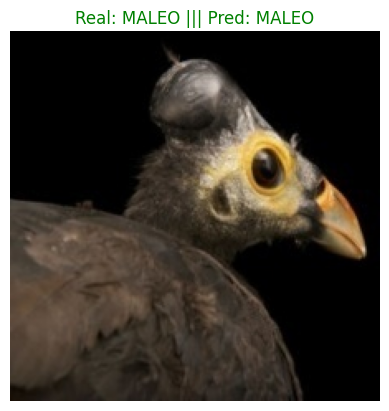

In [45]:
display_image_and_prediction(model, test_data, "MALEO")

In [37]:
def birds_class_pred(row, col):

    for i in range(1,row*col+1):

        plt.figure(figsize = (10,10))


        plt.subplot(row,col,i)

        display_image_and_prediction(model, test_data, classes[random.randint(0, n_classes - 1)]);

1/1 [==============================] - 0s 31ms/step


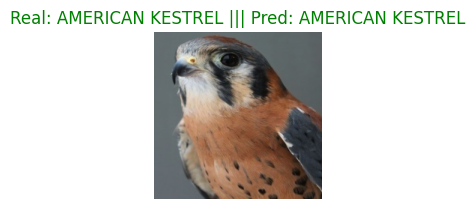

1/1 [==============================] - 0s 27ms/step


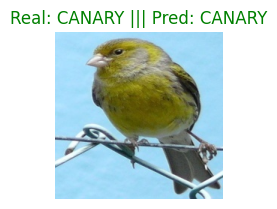

1/1 [==============================] - 0s 25ms/step


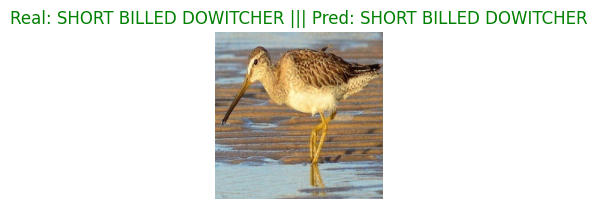

1/1 [==============================] - 0s 25ms/step


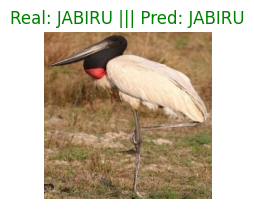

1/1 [==============================] - 0s 24ms/step


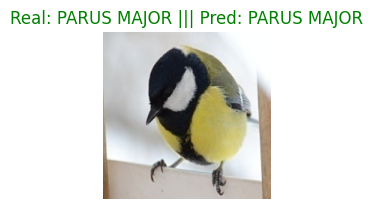

1/1 [==============================] - 0s 29ms/step


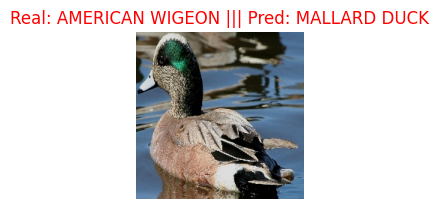

1/1 [==============================] - 0s 25ms/step


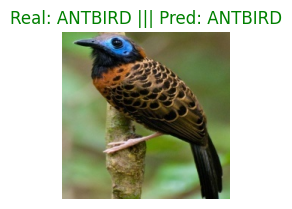

1/1 [==============================] - 0s 25ms/step


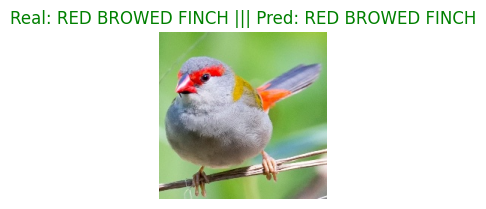

1/1 [==============================] - 0s 27ms/step


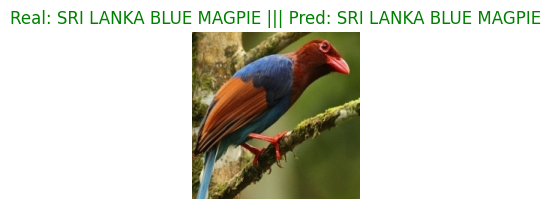

1/1 [==============================] - 0s 25ms/step


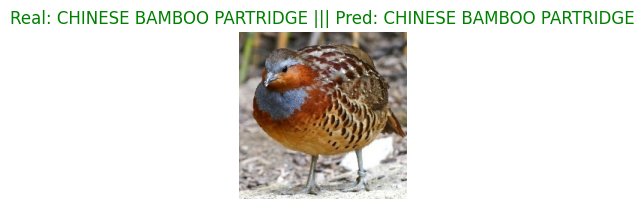

1/1 [==============================] - 0s 28ms/step


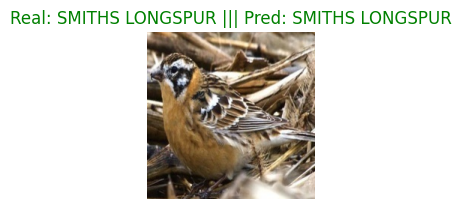

1/1 [==============================] - 0s 37ms/step


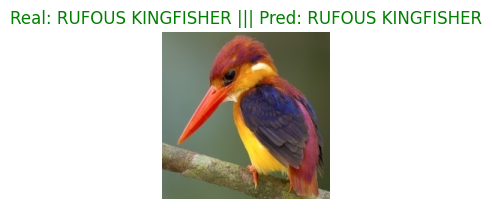

1/1 [==============================] - 0s 28ms/step


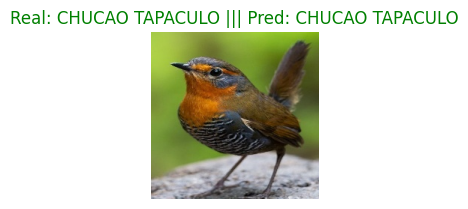

1/1 [==============================] - 0s 25ms/step


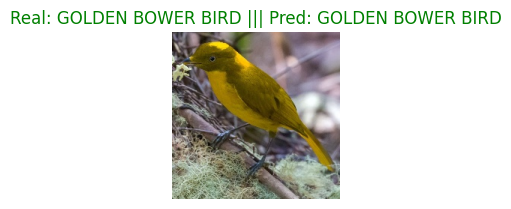

1/1 [==============================] - 0s 27ms/step


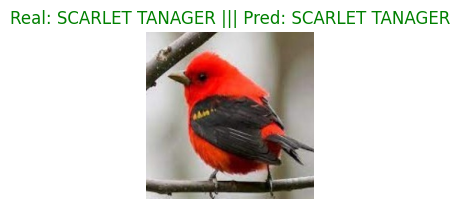

1/1 [==============================] - 0s 32ms/step


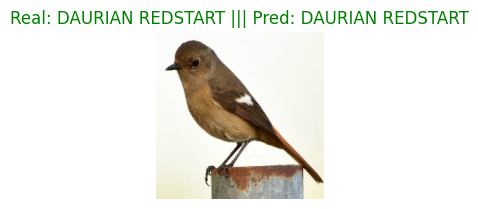

In [38]:
birds_class_pred(4,4)

**Predicción Usuario**

Para que el usuario pueda hacer una predicción con una imagen y clase propia, es necesario que busque la imagen de un ave de la siguiente lista

In [56]:
classes

['WATTLED LAPWING',
 'BLOOD PHEASANT',
 'HARLEQUIN DUCK',
 'DEMOISELLE CRANE',
 'STRIPPED MANAKIN',
 'BULWERS PHEASANT',
 'TURKEY VULTURE',
 'SAND MARTIN',
 'SATYR TRAGOPAN',
 'WILD TURKEY',
 'GREY HEADED FISH EAGLE',
 'EARED PITA',
 'BORNEAN BRISTLEHEAD',
 'WRENTIT',
 'MAGPIE GOOSE',
 'FAIRY BLUEBIRD',
 'CERULEAN WARBLER',
 'EURASIAN BULLFINCH',
 'PARAKETT  AUKLET',
 'BLACK SKIMMER',
 'AMERICAN AVOCET',
 'BUSH TURKEY',
 'RED TAILED THRUSH',
 'TRICOLORED BLACKBIRD',
 'RED WINGED BLACKBIRD',
 'WOOD THRUSH',
 'SQUACCO HERON',
 'BLACK FRANCOLIN',
 'WATTLED CURASSOW',
 'COMMON LOON',
 'GOLDEN PIPIT',
 'SPLENDID WREN',
 'SPOTTED WHISTLING DUCK',
 'SCARLET FACED LIOCICHLA',
 'NORTHERN CARDINAL',
 'GREATER PRAIRIE CHICKEN',
 'FASCIATED WREN',
 'PAINTED BUNTING',
 'ORANGE BRESTED BUNTING',
 'PUFFIN',
 'CHUKAR PARTRIDGE',
 'GILA WOODPECKER',
 'ORNATE HAWK EAGLE',
 'GRAY KINGBIRD',
 'RED WISKERED BULBUL',
 'HORNED SUNGEM',
 'EUROPEAN GOLDFINCH',
 'SUPERB STARLING',
 'EASTERN TOWEE',
 'OSPREY',
 

Una vez que ya se tenga la imagen se debe correr esta celda, se le pedirá al usuario subir su imagen y el nombre real de la clase y el modelo hará la predicción y la propabilidad de que este en lo correcto

Saving GreenMagpie_test.jpg to GreenMagpie_test.jpg


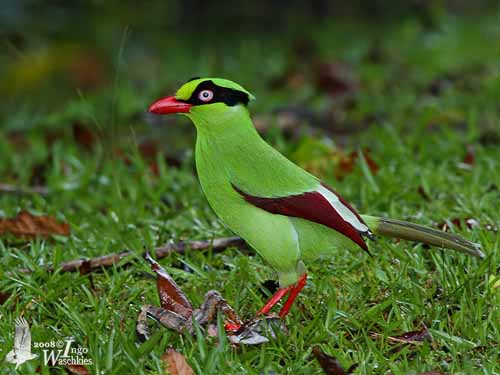

Ingrese la clase real de la imagen: Green MAGPIE
1/1 [==============================] - 0s 27ms/step


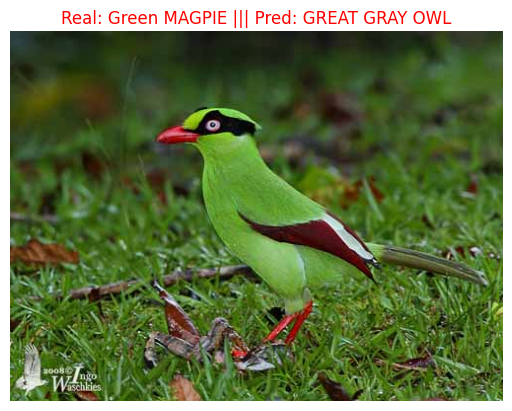

Predicción: GREAT GRAY OWL, Clase Real: Green MAGPIE, Probabilidad: 0.303135484457016


In [55]:
from google.colab import files
from IPython.display import Image
import os
import random
import matplotlib.pyplot as plt

def load_and_preprocess_uploaded_image(img_path, target_size=(224, 224)):
    try:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize the image
        return img_array
    except Exception as e:
        print(f"Error loading image: {str(e)}")
        return None


def predict_with_user_upload(model, class_indices):
    # Permitir al usuario subir una imagen
    uploaded = files.upload()

    # Obtener la ruta del archivo de la imagen cargada
    img_path = list(uploaded.keys())[0]

    # Mostrar la imagen cargada
    display(Image(filename=img_path))

    # Solicitar al usuario que ingrese la clase real de la imagen
    actual_class = input("Ingrese la clase real de la imagen: ")

    if isinstance(class_indices, list):
        class_indices = {str(i): class_name for i, class_name in enumerate(class_indices)}

    # Load and preprocess the uploaded image
    img_array = load_and_preprocess_uploaded_image(img_path)

    if img_array is not None:
        # Make a prediction
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction)
        predicted_class_name = class_indices.get(str(predicted_class), f"Clase {predicted_class}")

        color = 'green' if actual_class == predicted_class_name else 'red'

        plt.imshow(mpimg.imread(img_path))
        plt.title(f"Real: {actual_class} ||| Pred: {predicted_class_name}", color=color)
        plt.axis("off")
        plt.show()

        print(f"Predicción: {predicted_class_name}, Clase Real: {actual_class}, Probabilidad: {np.max(prediction)}")
    else:
        print("Error al cargar y procesar la imagen.")


# Ejemplo de uso
predict_with_user_upload(model, classes)
